In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
import unicodedata

In [4]:
hojas = pd.read_excel(r"C:\Users\santi\OneDrive\Desktop\Python\Comedores populares.xlsx", sheet_name=None)
columnas = ["Departamento", "Provincia", "Distrito", "Nombre_Comedor"]

for n, hoja in hojas.items():
    hoja.columns = columnas
    hoja = hoja.dropna(subset=columnas)
    hojas[n] = hoja

df_total = pd.concat(hojas.values(), ignore_index=True)

In [5]:
def norm(s):
    s = str(s).upper().strip()
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("utf-8")
    s = " ".join(s.split())
    return s

for c in ["Departamento", "Provincia", "Distrito"]:
    df_total[c] = df_total[c].apply(norm)

df_total = df_total[df_total["Departamento"].str.len() > 2]


In [6]:
df_lima = df_total[(df_total["Departamento"] == "LIMA") & (df_total["Provincia"] == "LIMA METROPOLITANA")].copy()

conteo = (
    df_lima["Distrito"]
    .value_counts()
    .rename_axis("Distrito")
    .reset_index(name="N_comedores")
)

In [9]:
gdf_distritos = gpd.read_file(r"C:\Users\santi\Downloads\DISTRITOS_LIMITES\DISTRITOS.shp")

for c in ["DEPARTAMEN", "PROVINCIA", "DISTRITO"]:
    gdf_distritos[c] = gdf_distritos[c].apply(norm)

ubigeo_lima = gdf_distritos[
    (gdf_distritos["DEPARTAMEN"] == "LIMA") &
    (gdf_distritos["PROVINCIA"] == "LIMA")
].copy()

gdf_merge = ubigeo_lima.merge(conteo, left_on="DISTRITO", right_on="Distrito", how="left")
gdf_merge["N_comedores"] = gdf_merge["N_comedores"].fillna(0).astype(int)
gdf_merge["Tiene_comedor"] = gdf_merge["N_comedores"] > 0

In [10]:
import unicodedata

def norm(s):
    s = str(s).upper().strip()
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("utf-8")
    s = " ".join(s.split())
    return s

gdf_distritos["DISTRITO"] = gdf_distritos["DISTRITO"].apply(norm)
conteo["Distrito"] = conteo["Distrito"].apply(norm)

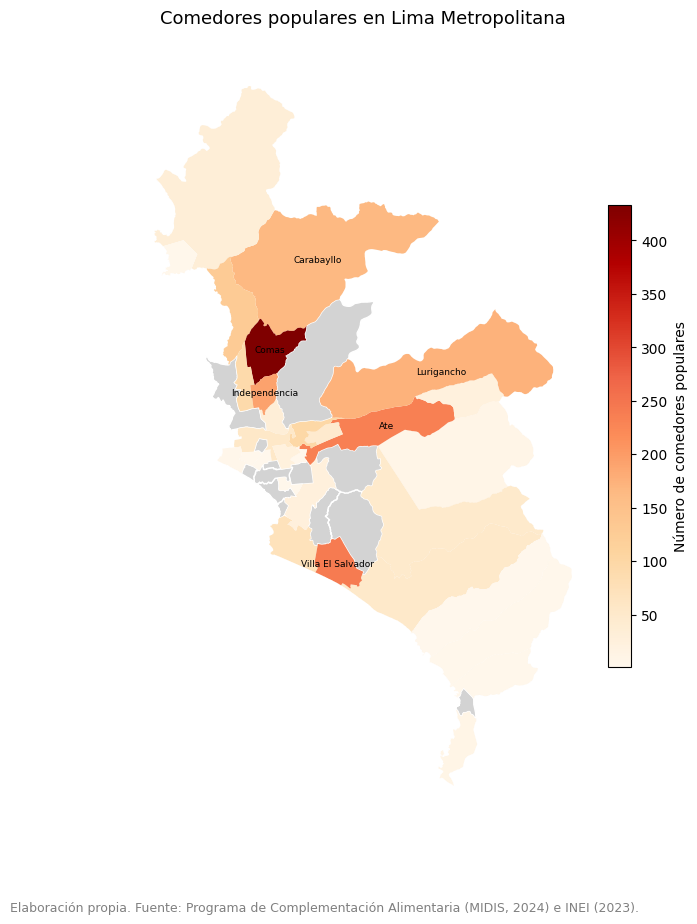

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

# Base gris
gdf_merge.plot(ax=ax, color="lightgray", edgecolor="white")

# Distritos con comedores (gradiente OrRd)
gdf_merge[gdf_merge["Tiene_comedor"]].plot(
    ax=ax, column="N_comedores", cmap="OrRd", legend=True,
    legend_kwds={
        "label": "Número de comedores populares",
        "orientation": "vertical",
        "shrink": 0.6,
        "pad": 0.02
    }
)

# Etiquetas para distritos con más de 150 comedores
for _, row in gdf_merge[gdf_merge["N_comedores"] > 150].iterrows():
    x, y = row.geometry.centroid.coords[0]
    ax.text(x, y, row["DISTRITO"].title(), fontsize=6.5, color="black", ha="center", va="center")

plt.title("Comedores populares en Lima Metropolitana", fontsize=13, pad=20)
plt.axis("off")

plt.figtext(
    0.5, 0.02,
    "Elaboración propia. Fuente: Programa de Complementación Alimentaria (MIDIS, 2024) e INEI (2023).",
    ha="center", fontsize=9, color="gray", wrap=True
)

plt.savefig(
    r"C:\Users\santi\OneDrive\Documentos\GitHub\Geopandas-Comedores-Populares\output\mapa_comedores.png",
    dpi=300, bbox_inches="tight", facecolor="white"
)
plt.show()

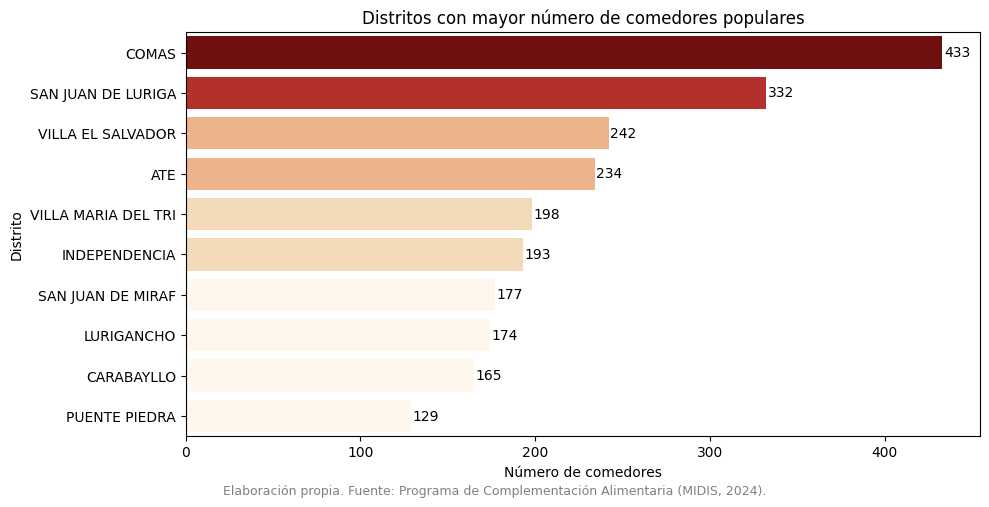

In [17]:
top = conteo.sort_values("N_comedores", ascending=False).head(10).copy()
top["N_comedores"] = top["N_comedores"].astype(int)

# Paleta discreta "OrRd"
n_colors = 6
cmap = mpl.colormaps.get_cmap("OrRd")
colors_discretos = [mcolors.to_hex(cmap(i / (n_colors - 1))) for i in range(n_colors)]
bins = np.linspace(top["N_comedores"].min(), top["N_comedores"].max(), n_colors + 1)
top["Grupo"] = pd.cut(top["N_comedores"], bins=bins, labels=False, include_lowest=True)
top["Color"] = top["Grupo"].apply(lambda i: colors_discretos[int(i)])

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=top, x="N_comedores", y="Distrito",
    hue="Distrito", dodge=False,
    palette=top.set_index("Distrito")["Color"].to_dict(),
    legend=False
)

for i, v in enumerate(top["N_comedores"]):
    ax.text(v + 1, i, f"{v}", va="center", color="black")

plt.xlabel("Número de comedores")
plt.ylabel("Distrito")
plt.title("Distritos con mayor número de comedores populares")
plt.tight_layout()

plt.figtext(
    0.5, 0.001,
    "Elaboración propia. Fuente: Programa de Complementación Alimentaria (MIDIS, 2024).",
    ha="center", fontsize=9, color="gray", wrap=True
)

plt.savefig(
    r"C:\Users\santi\OneDrive\Documentos\GitHub\Geopandas-Comedores-Populares\output\grafico_barras_comedores.png",
    dpi=300, bbox_inches="tight", facecolor="white"
)
plt.show()